### Identify Long Homopolymer Areas on Fasta

In [156]:
def region_toks(region):
    return region.replace(":", "\t").replace("-", "\t").split("\t")

def region_chr(region):
    return region_toks[0]

def region_start(region):
    return int(region_toks(region)[1])

def region_end(region):
    return int(region_toks(region)[2])

In [157]:
import io
import subprocess
import re

# extract bases 
def get_bases(ref, region):
    cmd = "bedtools getfasta -fi %s -bed -" % ref
    beddata = "%s\t%s\t%s\n" % tuple(region_toks(region))
    start = region_start(region)
    with subprocess.Popen(cmd, stdout=subprocess.PIPE, stdin=subprocess.PIPE, shell=True) as proc:
        stdout = proc.communicate(input=beddata.encode())[0]
        bases = stdout.decode().split('\n')[1].upper()
        return (start, bases)


In [158]:
import re

# find homopolymer areas
def get_homopolymer_spans(start, bases, hmerSize):
    patt = re.compile("(T{%d,})|(A{%d,})|(G{%d,})|(C{%d,})" % (hmerSize + 1, hmerSize + 1, hmerSize + 1, hmerSize + 1))
    spans = [(x.span()[0] + start, x.span()[1] + start - 1) for x in re.finditer(patt, bases)]
    return spans

#spans = get_homopolymer_spans(start, bases, hmerSize)
#spans

### get alleles from a vcf file

In [159]:
# params
vcf = "output/test1/baseline/test1-baseline.vcf"

def get_vcf_alleles(vcf):
    cmd = "grep -E -v '^#' %s | cut -f 2,4,5" % vcf
    with subprocess.Popen(cmd, stdout=subprocess.PIPE, stdin=subprocess.PIPE, shell=True) as proc:
        stdout = proc.communicate(input="".encode())[0]
        alleles = [form_allele(x.split("\t")) for x in stdout.decode().split('\n')[:-1]]
        return alleles

def form_allele(a):
    start = int(a[0])
    length = len(a[1])
    return (start, start+length-1, a[1], a[2])
    
#alleles = get_vcf_alleles(vcf)
#alleles[0:12]

In [160]:
def span_complement(span, start, end):
    all = sum([list(x) for x in span], [])
    comp = []
    comp.append((start, all[0] - 1))
    it = iter(all[1:-1])
    for x in it:
        comp.append((x + 1, next(it) - 1))
    comp.append((all[-1] + 1, end))
    return comp

#non_homo_spans = span_complement(homo_spans, region_start(region), region_end(region))
#non_homo_spans[0:12]


In [161]:
import bisect

def loc_in_spans(spans, loc):
    locs = sum([list(x) for x in spans], [])
    return loc_in_flatten_spans(locs, loc)

def loc_in_flatten_spans(f_spans, loc):
    i = bisect.bisect_left(f_spans, loc)
    if i < len(f_spans) and f_spans[i] == loc:
        return True
    else:
        return bool(i & 1)
    

def alleles_in_spans(spans, alleles):
    locs = sum([list(x) for x in spans], [])
    return [x for x in alleles if loc_in_flatten_spans(locs, x[0])]
    
    
#print(loc_in_spans(homo_spans, 6484073))

In [219]:
import json

spans_db = {}
def summarize_test(tname, tver, hmerSize, ref, region):

    # make sure we have bases
    if not ref in spans_db:
        spans_db[ref] = {}
    if not region in spans_db[ref]:
        spans_db[ref][region] = get_bases(ref, region)[1]
    
    # make sure we have spans
    if not hmerSize in spans_db:
        spans_db[hmerSize] = {}
        spans_db[hmerSize]["homo_spans"] = get_homopolymer_spans(region_start(region), spans_db[ref][region], hmerSize)
        spans_db[hmerSize]["non_homo_spans"] = span_complement(spans_db[hmerSize]["homo_spans"], region_start(region), region_end(region))
        #print("hmerSize %d homo_spans %d" % (hmerSize, len(spans_db[hmerSize]["homo_spans"])))
    
    # get alleles
    vcf = "output/{0}/{1}/{0}-{1}.vcf".format(tname, tver)
    info = {}
    info["alleles"] = get_vcf_alleles(vcf)

    # map to homo/non-homo
    info["homo_alleles"] = alleles_in_spans(spans_db[hmerSize]["homo_spans"], info["alleles"])
    info["non_homo_alleles"] = alleles_in_spans(spans_db[hmerSize]["non_homo_spans"], info["alleles"])
    
    info["lengths"] = "%d alleles %d homo_alleles %d non_homo_alleles" % (
            len(info["alleles"]),
            len(info["homo_alleles"]),
            len(info["non_homo_alleles"]),
        )
    
    info["row"] = {
        "region": region,
        "hmerSize": hmerSize,
        "homo_spans": len(spans_db[hmerSize]["homo_spans"]),
        "tname": tname,
        "tver": tver,
        "alleles": len(info["alleles"]),
        "homo_alleles": len(info["homo_alleles"]),
        "non_homo_alleles": len(info["non_homo_alleles"]),
    }
    
    # add anal info
    with open("output/{0}/{1}/{0}-{1}-anal.json".format(tname, tver)) as anal_file:
        anal = json.load(anal_file)
        info["row"]["snps"] = int(anal["snps"])
        info["row"]["indels"] = int(anal["indels"])
        info["row"]["opts"] = anal["_opts"]
    
    return info
    
def check_info(info):
    # convert lists of alleles to dictionaries with start as the key
    dicts = {}
    for name in ["alleles", "homo_alleles", "non_homo_alleles"]:
        dicts[name] = {x[0]:x for x in info[name]}
        
    # make sure home and non_homo are disjoined
    h_keys = set(dicts["homo_alleles"].keys())
    nh_keys = set(dicts["non_homo_alleles"].keys())
    nh_h_keys = h_keys.intersection(nh_keys)
    #print("h_keys %d nh_keys %d nh_h_keys %d" % (len(h_keys), len(nh_keys), len(nh_h_keys)))
    if len(nh_h_keys):
        print("ERROR: homo and non_homo sets intersect!")
        print(nh_h_keys)
    
    # make sure all homo and non_homo are in alleles
    a_keys = set(dicts["alleles"].keys())
    a_h_keys = a_keys.intersection(h_keys)
    #print("a_keys %d h_keys %d a_h_keys %d" % (len(a_keys), len(h_keys), len(a_h_keys)))
    if len(h_keys) != len(a_h_keys):
        print("ERROR: allels and homo sets disjointed!")
    a_nh_keys = a_keys.intersection(nh_keys)
    #print("a_keys %d nh_keys %d a_nh_keys %d" % (len(a_keys), len(nh_keys), len(a_nh_keys)))
    if len(nh_keys) != len(a_nh_keys):
        print("ERROR: allels and non-homo sets disjointed!")
    
    # make sure homo+non-homo=alleles
    diff_keys = a_keys.difference(h_keys.union(nh_keys))
    if len(diff_keys):
        print("ERROR: %d keys missing from homo+non-homo!" % len(diff_keys))
        for key in diff_keys:
            print(dicts["alleles"][key])
    
    
    
tests = {
            "test1": [
                {
                    "hmerSize": 12,
                    "region": "chr20:6000000-7000000",
                    "ref": "../ref/Homo_sapiens_assembly38.fasta",
                    "versions": ["baseline", "baseline12m", "collapse12", "collapse12m"]
                },
                {
                    "hmerSize": 10,
                    "region": "chr20:6000000-7000000",
                    "ref": "../ref/Homo_sapiens_assembly38.fasta",
                    "versions": ["baseline", "baseline10m", "collapse10", "collapse10m", "collapse10m1"]
                }
            ]
        }

spans_db["info"] = {}
df_rows = []
for tname,tdicts in tests.items():
    spans_db["info"][tname] = {}
    for tdict in tdicts:
        for tver in tdict["versions"]:
            hmerSize = tdict["hmerSize"]
            if not tver in spans_db["info"][tname]:
                spans_db["info"][tname][tver] = {}
            info = summarize_test(tname, tver, tdict["hmerSize"], tdict["ref"], tdict["region"])
            spans_db["info"][tname][tver][hmerSize] = info
            df_rows.append(info["row"])
            #print("%s-%s: %s" % (tname, tver, info["lengths"]))
            check_info(info)
            
import pandas as pd
info_df = pd.DataFrame(df_rows)
info_df

# add homo_alleles ratio
def calc_homo_alleles_ratio(x, col):
    hmerSize = x["hmerSize"]
    v = x[col]
    base = info_df[info_df["hmerSize"] == hmerSize]
    base = base[base["tver"] == "baseline"]
    base =  base[col].values[0]
    return v / base
    
info_df['homo_alleles_ratio'] = info_df.apply(lambda x: calc_homo_alleles_ratio(x, "homo_alleles"), axis=1)
info_df['non_homo_alleles_ratio'] = info_df.apply(lambda x: calc_homo_alleles_ratio(x, "non_homo_alleles"), axis=1)
info_df

,region,hmerSize,homo_spans,tname,tver,alleles,homo_alleles,non_homo_alleles,snps,indels,opts,homo_alleles_ratio,non_homo_alleles_ratio
0,chr20:6000000-7000000,12,176,test1,baseline,3071,179,2892,1450,1622,,1.000000,1.000000
1,chr20:6000000-7000000,12,176,test1,baseline12m,2957,94,2863,1450,1508,"--ultima-flow-matrix-mods 10,12,11,12",0.525140,0.989972
2,chr20:6000000-7000000,12,176,test1,collapse12,3043,155,2888,1439,1607,--ultima-assembly-collapse-hmer-size 12,0.865922,0.998617
3,chr20:6000000-7000000,12,176,test1,collapse12m,2893,31,2862,1434,1460,--ultima-assembly-collapse-hmer-size 12 --ulti...,0.173184,0.989627
4,chr20:6000000-7000000,10,247,test1,baseline,3071,243,2828,1450,1622,,1.000000,1.000000
5,chr20:6000000-7000000,10,247,test1,baseline10m,2847,111,2736,1428,1420,"--ultima-flow-matrix-mods 8,10,9,10,11,10,12,10",0.456790,0.967468
6,chr20:6000000-7000000,10,247,test1,collapse10,3071,241,2830,1423,1650,--ultima-assembly-collapse-hmer-size 10,0.991770,1.000707
7,chr20:6000000-7000000,10,247,test1,collapse10m,2797,40,2757,1413,1385,--ultima-assembly-collapse-hmer-size 10 --ulti...,0.164609,0.974894
8,chr20:6000000-7000000,10,247,test1,collapse10m1,3060,239,2821,1419,1642,--ultima-assembly-collapse-hmer-size 10 --ulti...,0.983539,0.997525


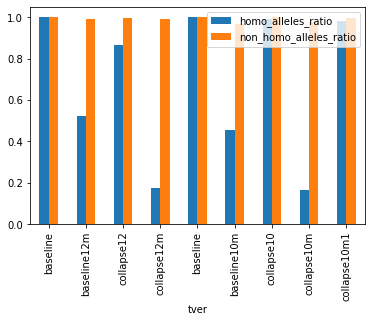

In [163]:
import matplotlib.pyplot as plt

info_df.plot(x ='tver', y=['homo_alleles_ratio', 'non_homo_alleles_ratio'], kind = 'bar')
plt.show()

In [164]:
spans_db["info"]["test1"]["collapse12m"][12]["homo_alleles"]

[(6009322, 6009326, 'CAAAA', 'C'),
 (6010077, 6010077, 'A', 'ATTTG'),
 (6011572, 6011573, 'CT', 'C'),
 (6019691, 6019691, 'C', 'T'),
 (6019692, 6019692, 'T', 'C'),
 (6023954, 6023954, 'A', 'C'),
 (6023955, 6023955, 'T', 'A'),
 (6029138, 6029139, 'AT', 'A'),
 (6083706, 6083707, 'CA', 'C'),
 (6097803, 6097804, 'GT', 'G'),
 (6103767, 6103768, 'GT', 'G'),
 (6107210, 6107210, 'A', 'G'),
 (6181713, 6181713, 'A', 'AGTC'),
 (6206277, 6206277, 'T', 'C'),
 (6218092, 6218092, 'A', 'C'),
 (6261201, 6261204, 'ATTT', 'A'),
 (6315820, 6315821, 'CT', 'C'),
 (6324955, 6324955, 'A', 'C'),
 (6360638, 6360639, 'TT', 'T'),
 (6386495, 6386496, 'GA', 'G'),
 (6399695, 6399697, 'AAT', 'A'),
 (6537054, 6537054, 'T', 'G'),
 (6537055, 6537055, 'T', 'G'),
 (6592981, 6592981, 'T', 'TC'),
 (6724932, 6724932, 'T', 'TTTGTTTG,TTTTGTTTG'),
 (6765671, 6765672, 'TA', 'T'),
 (6782922, 6782922, 'T', 'TC'),
 (6797282, 6797283, 'CT', 'C'),
 (6889962, 6889966, 'AAAAA', 'A'),
 (6889963, 6889963, 'A', '*,AAAT'),
 (6976926, 69769

In [165]:
import pprint

# find alleles delta between two versions (home or non_homo)
def get_ver_alleles(v, homo):
    col = "homo_alleles" if homo else "non_homo_alleles" 
    hmerSize = v[0]
    tname = v[1]
    tver = v[2]
    return spans_db["info"][tname][tver][hmerSize][col]

def get_ver_alleles_delta(v1, v2, homo):
    a1 = set(get_ver_alleles(v1, homo))
    a2 = set(get_ver_alleles(v2, homo))
    
    d1 = sorted(list(a1.difference(a2)))
    d2 = sorted(list(a1.intersection(a2)))
    d3 = sorted(list(a2.difference(a1)))
    
    #pprint.pprint(d1[0:10])
    #pprint.pprint(d3[0:10])    
    
    return (a1, d1, d2, d3, a2)

vdiffs = [
    ((12, "test1", "baseline"), (12, "test1", "collapse12m")),
    ((10, "test1", "baseline"), (10, "test1", "collapse10m")),
]

for vdiff in vdiffs:
        delta = get_ver_alleles_delta(*vdiff, False)
        delta_len = [len(x) for x in delta]
        print("non_homo_alleles: ", *vdiff, "\n", delta_len, "\n", round(delta_len[1] / delta_len[0], 3), round(delta_len[3] / delta_len[4], 3))


non_homo_alleles:  (12, 'test1', 'baseline') (12, 'test1', 'collapse12m') 
 [2892, 70, 2822, 40, 2862] 
 0.024 0.014
non_homo_alleles:  (10, 'test1', 'baseline') (10, 'test1', 'collapse10m') 
 [2828, 140, 2688, 69, 2757] 
 0.05 0.025


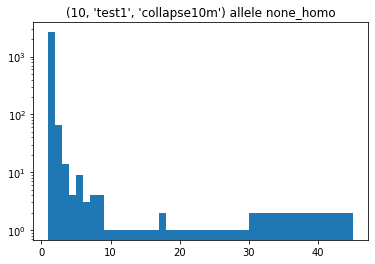

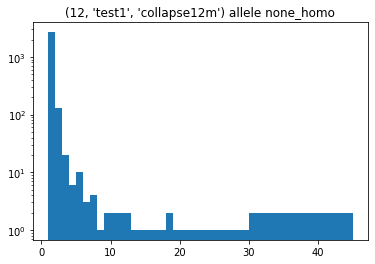

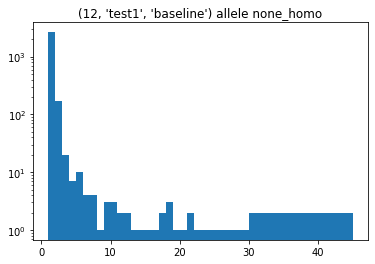

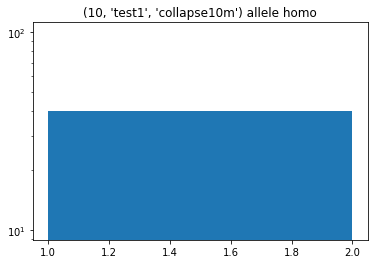

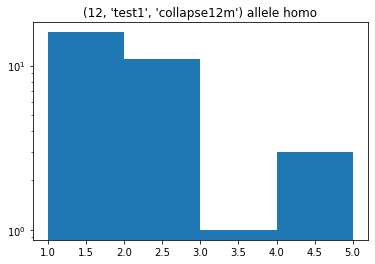

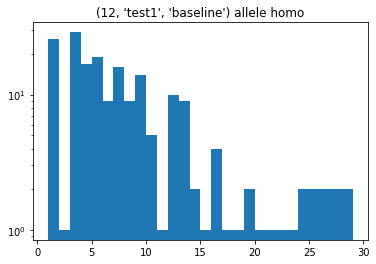

In [235]:
import numpy as np

# plot histogram of lengths of alleles
def plot_allele_hist(v, homo):
    a = get_ver_alleles(v, homo)
    lens = np.array([len(x[2]) for x in a])
    plt.hist(lens, bins=np.unique(lens)) 
    plt.title(str(v) + " allele %s" % ("homo" if homo else "none_homo")) 
    plt.yscale("log")
    plt.show()

for homo in [False, True]:
    plot_allele_hist((10, "test1", "collapse10m"), homo)
    plot_allele_hist((12, "test1", "collapse12m"), homo)
    plot_allele_hist((12, "test1", "baseline"), homo)
